In [1]:
import numpy as np
import matplotlib.pyplot as plt

sigma = lambda z : 1 / (1 + np.exp(-z))
d_sigma = lambda z : np.cosh(z / 2) ** (-2) / 4

def training_data(N=10):
    x = np.array([np.random.randint(0, 2) for _ in range(N)])
    y = np.array([abs(1 - i) for i in x])
    # x_vec = x.reshape(len(x), 1)
    x_vec = x.reshape(1, len(x))
    y_vec = y.reshape(len(y), 1)
    return x_vec, y_vec

def reset(n1 = 1, n2 = 1, random=np.random):
    global W1, W2, W3, b1, b2, b3
    W1 = random.randn(n1, 1) / 2
    W2 = random.randn(n2, n1) / 2
    W3 = random.randn(1, n2) / 2
    b1 = random.randn(n1, 1) / 2
    b2 = random.randn(n2, 1) / 2
    b3 = random.randn(1, 1) / 2
    
def network_function(a0):
    # z1 = W1 @ a0.T + b1
    z1 = W1 @ a0 + b1
    a1 = sigma(z1)
    z2 = W2 @ a1 + b2
    a2 = sigma(z2)
    z3 = W3 @ a2 + b3
    a3 = sigma(z3)
    return a0, z1, a1, z2, a2, z3, a3

def cost(x, y):
    cost_arr = (network_function(x)[-1] - y.T) ** 2
    return np.ndarray.sum(cost_arr) / x.size

    # return np.linalg.norm(network_function(x)[-1] - y) ** 2 / x.size

BACKPROPAGATION<br>
&emsp;Cost L = 1/N * (sum of L_k over N training cases)<br>

LAYER 3:<br>

dz3/dW3 = a2<br>
dz3/db3 = 1<br>
da3/dz3 = d_sigma(z3)<br>

&emsp;e3 = dL/da3 = 2 * (a3 - y)<br>
&emsp;dL/dW3 = dL/da3 * da3/dz3 * dz3/dW3<br>
&emsp;dL/db3 = dL/da3 * da3/dz3 * dz3/db3<br>

LAYER 2:<br>

da3/da2 = d_sigma(z3) * W3
dz2/dW2 = a1<br>
dz2/db2 = 1<br>
da2/dz2 = d_sigma(z2)<br>

&emsp;e2 = e3 * da3/da2<br>
&emsp;dL/dW2 = e2 * da2/dz2 * dz2/dW2<br>
&emsp;dL/db2 = e2 * da2/dz2 * dz2/db2<br>

LAYER 1:<br>

da2/da1 = d_sigma(z2) * W2
dz1/dW1 = a0<br>
dz1/db1 = 1<br>
da1/dz1 = d_sigma(z1)<br>

&emsp;e1 = e2 * da2/da1<br>
&emsp;dL/dW1 = e1 * da1/dz1 * dz1/dW1<br>
&emsp;dL/db1 = e1 * da1/dz1 * dz1/db1<br>

In [2]:
def jacobians(x, y):
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    
    # Layer 3
    dz3dW3 = a2
    dz3db3 = 1
    da3dz3 = d_sigma(z3)    # (1, N)
    e3 = 2 * (a3 - y.T)     # (1, N)
    # print(f'{e3.shape} {da3dz3.shape} {dz3dW3.shape}')
    dLdW3 = e3 * da3dz3 @ dz3dW3.T / x.size # (No. nodes a3, No. nodes a2)
    dLdb3 = np.sum(e3 * da3dz3 * dz3db3, keepdims=True) / x.size # (No. nodes a3, 1)
    
    # return dz3dW3, dz3db3, da3dz3, e3, dLdW3, dLdb3
    
    # Layer 2
    # da3da2 = d_sigma(z3) * W3
    # e2 = e3 * da3da2
    e2 = ((e3 * d_sigma(z3)).T @ W3).T
    # print(f'{e3.shape} {W3.shape} {d_sigma(z3).shape}')
    dz2dW2 = a1
    dz2db2 = 1
    da2dz2 = d_sigma(z2)
    # print(f'{e2.shape} {da2dz2.shape} {dz2dW2.shape}')
    dLdW2 = e2 * da2dz2 @ dz2dW2.T / x.size
    dLdb2 = np.sum(e2 * da2dz2 * dz2db2, keepdims=True) / x.size
        
    # # Layer 1
    # da2da1 = d_sigma(z2) * W2
    # e1 = e2 * da2da1
    e1 = ((e2 * d_sigma(z2)).T @ W2).T
    dz1dW1 = a0
    dz1db1 = 1
    da1dz1 = d_sigma(z1)
    # print(f'{e1.shape} {da1dz1.shape} {dz1dW1.shape}')
    dLdW1 = e1 * da1dz1 @ dz1dW1.T / x.size
    dLdb1 = np.sum(e2 * da1dz1 * dz1db1, keepdims=True) / x.size
    
    return dLdW1, dLdb1, dLdW2, dLdb2, dLdW3, dLdb3

# reset()
# x, y = training_data()
# # dz3dW3, dz3db3, da3dz3, e3, dLdW3, dLdb3 = jacobians(x, y)
# dLdW1, dLdb1 = jacobians(x, y)
# print(f'dLdW3 {dLdW1}')
# print(f'dLdb3 {dLdb1}')

In [3]:
def training(x, y, iterations=10, step=1, noise=1):
    global W1, W2, W3, b1, b2, b3, prev_cost
    i = 1
    cost_list = []
    change_list = []
    
    while iterations >= 0:
        curr_cost = cost(x, y)
        cost_list.append(curr_cost)
        
        # calculate cost change
        change = abs((curr_cost - prev_cost) / prev_cost)
        # print(change)
        
        # if cost change <= .0001
        #   1. update step?
        #   2. stop?
        
        # if change <= .000001:
        #     step = step / 2

        # if change <= .000001: 
        #     print('Cost change <= .0001! CONVERGED!')
        #     return cost_list, change_list
        
        change_list.append(change)
        # print(f'\nCost: {curr_cost}\n\n\tChange: {change}')
        prev_cost = curr_cost
        dLdW1, dLdb1, dLdW2, dLdb2, dLdW3, dLdb3 = jacobians(x, y)
        
        dLdW1 = dLdW1 * (1 + np.random.randn() * noise)
        dLdb1 = dLdb1 * (1 + np.random.randn() * noise)
        dLdW2 = dLdW2 * (1 + np.random.randn() * noise)
        dLdb2 = dLdb2 * (1 + np.random.randn() * noise)
        dLdW3 = dLdW3 * (1 + np.random.randn() * noise)
        dLdb3 = dLdb3 * (1 + np.random.randn() * noise)
        
        W1 = W1 - dLdW1 * step
        W2 = W2 - dLdW2 * step
        W3 = W3 - dLdW3 * step
        b1 = b1 - dLdb1 * step
        b2 = b2 - dLdb2 * step
        b3 = b3 - dLdb3 * step
        
        # iteration_list.append(i)
        i += 1
        iterations -= 1
    
    # print(f'\nLast cost {cost(x, y)}')
    return cost_list, change_list

In [15]:
size = 1000
    # cost jumps -> correct output?
epochs = 10000
st = 1 # step

x, y = training_data(N=size)
reset()
prev_cost = 1
cost_list, change_list = training(x, y, iterations=epochs, step=st)

TEST

TESTING
In:	[[0 1 1 1 0 0 0 1 0 1]]
Out:	[[0.9892 0.0126 0.0126 0.0126 0.9892 0.9892 0.9892 0.0126 0.9892 0.0126]]


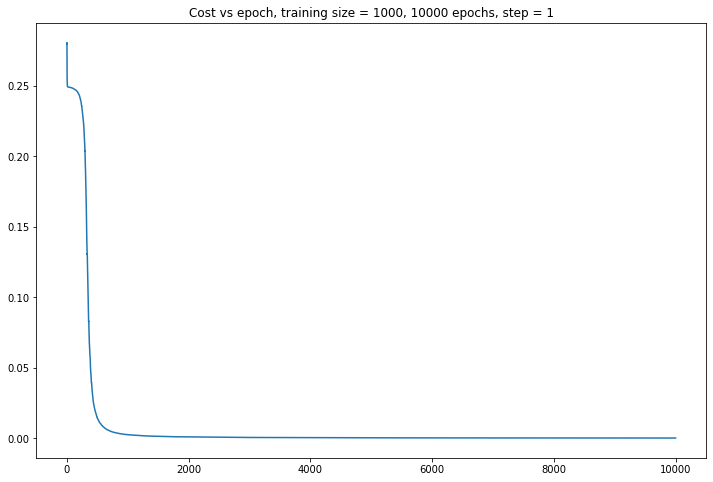

In [16]:
plt.rcParams["figure.figsize"] = (12, 8)
fig, ax = plt.subplots()
# plt.figure(figsize=(12, 8))
ax.plot(np.arange(len(cost_list)), cost_list)
ax.set_title(f'Cost vs epoch, training size = {size}, {epochs} epochs, step = {st}')

print("TESTING")
test_set = np.array([np.random.randint(0, 2) for _ in range(10)]).reshape(1, 10)
test_result = network_function(test_set)[-1]
print(f'In:\t{test_set}\nOut:\t{test_result.round(4)}')